In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from models import *
from utils import *
from PIL import Image
import numpy as np
import sys

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms

%matplotlib inline

print("mpl backend: ", plt.get_backend())

mpl backend:  module://ipykernel.pylab.backend_inline


In [24]:
def vis_layer(activ_map):
    plt.clf()
    plt.subplot(121)
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    raw_img = layer_output.data.cpu().numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img

In [21]:
torch.cuda.set_device(3)

n_classes = 1000 # using ImageNet pretrained weights

vgg16_c = VGG16_conv(n_classes).cuda()
conv_layer_indices = vgg16_c.get_conv_layer_indices()
print('VGG16 model:')
print(vgg16_c)

VGG16 model:
VGG16_conv (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU ()
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU ()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU ()
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU ()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU ()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU ()
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU 

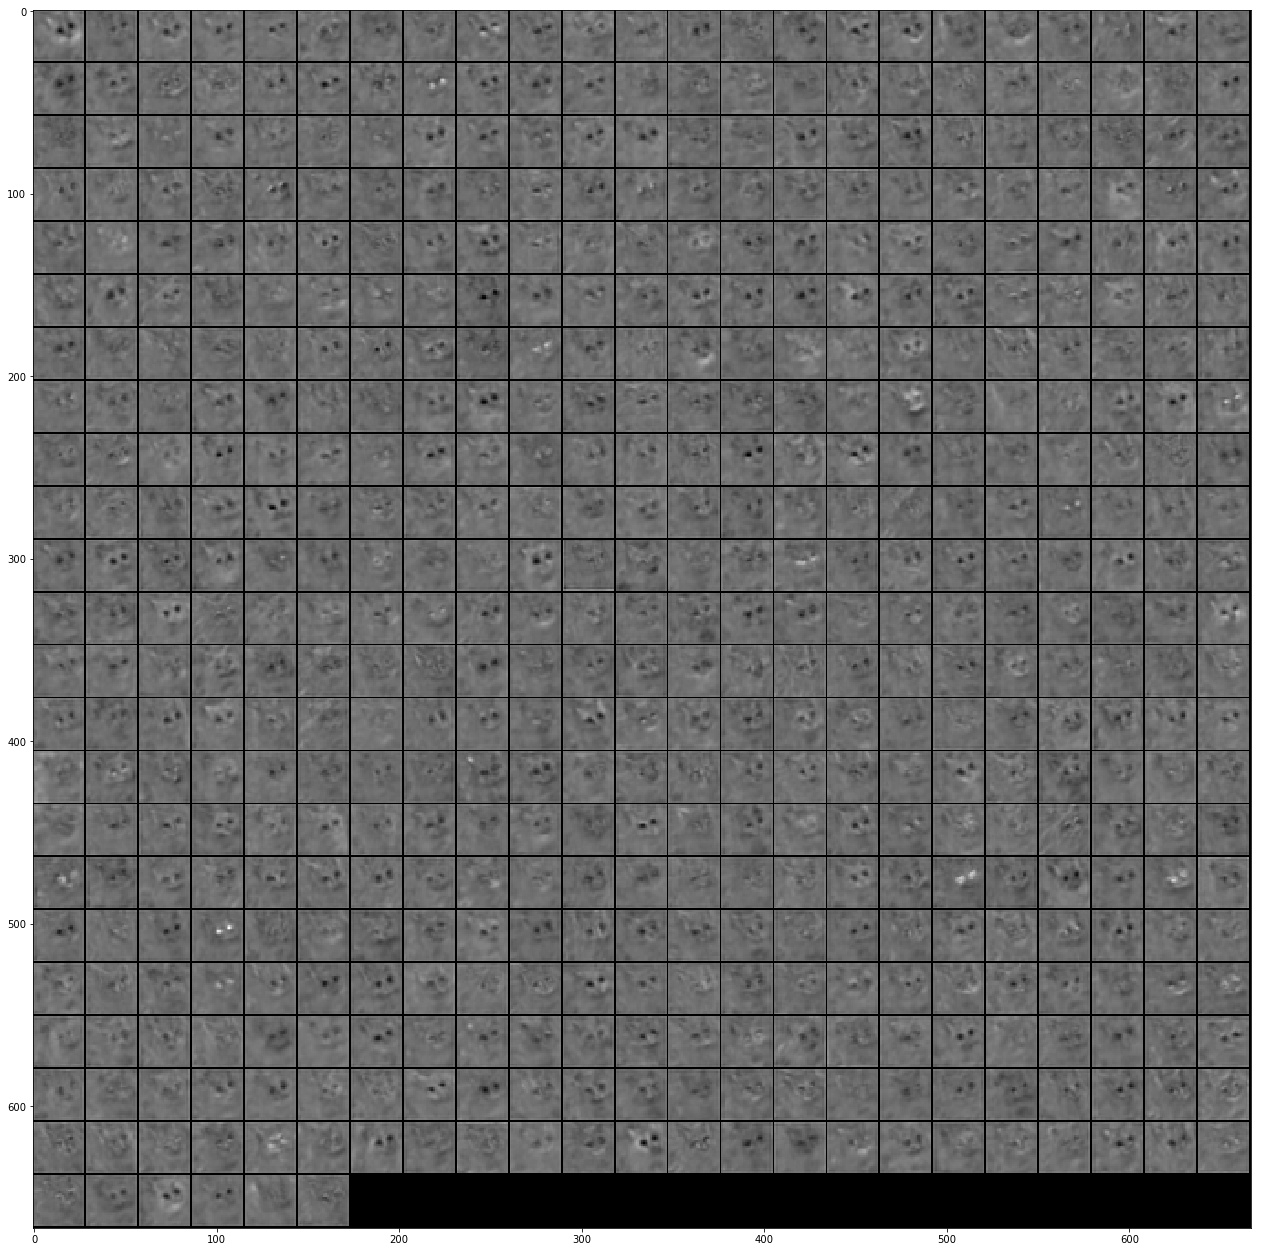

In [27]:
conv_out = vgg16_c(img_var)

plt.figure(figsize=(48,48))
vgg16_d = VGG16_deconv().cuda()


layer = 21

activ_map = vgg16_c.feature_outputs[layer].data.cpu().numpy()
activ_map = activ_map.transpose(1,2,3,0)
activ_map_grid = vis_grid(activ_map)
vis_layer(activ_map_grid)

Maps in layer 21: 512
Map 394:


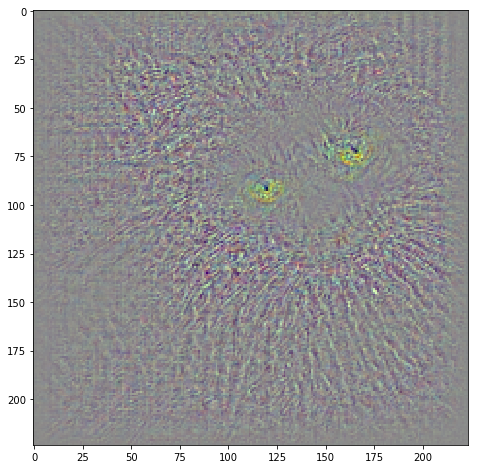

In [41]:
# only transpose convolve from Conv2d or ReLU layers
conv_layer = layer

n_maps = activ_map.shape[0]
print("Maps in layer {}:".format(conv_layer), n_maps)


_, map_x_dim, map_y_dim, _ = activ_map.shape
map_img_x_dim, map_img_y_dim, _ = activ_map_grid.shape
x_step = map_img_x_dim//(map_x_dim+1)


x_index = 3
y_index = 17
map_idx = int(x_step*y_index + x_index)
print("Map {}:".format(map_idx))

if map_idx >= n_maps:
    print('Invalid map selected')

decon = vgg16_d(vgg16_c.feature_outputs[layer][0][map_idx][None,None,:,:], conv_layer, map_idx, vgg16_c.pool_indices)
plt.figure(figsize=(8,8))
img = decon_img(decon)
plt.imshow(img)
